#  Portfolio Optimization with Transaction Costs

##  Overview

In real-world investing, every time you buy or sell stocks, you pay a **transaction cost**—something most theoretical portfolio optimizations ignore. This notebook explores how these costs can impact your portfolio, making our optimization approach more practical and realistic.

---

## Why Transaction Costs Matter

- **Every trade has a price:** Even small costs can add up and eat into your returns.
- **Frequent rebalancing = higher costs:** The more you change your portfolio, the more you pay.
- **Realistic investing:** Factoring in these costs helps you make smarter, more efficient decisions.

---

## What We Explore Here

- **Simulate transaction costs:** We add a penalty for changing your portfolio too much.
- **Compare portfolios:** See how a new optimized portfolio stacks up against your current one when costs are included.
- **Balance returns and costs:** By tuning a parameter (alpha), you can decide how much you care about maximizing returns vs. minimizing costs.
- **Visualize the trade-off:** See how your Sharpe ratio and turnover change as you adjust your sensitivity to transaction costs.

---

## How It Works

- **Transaction Cost Model:**  
  For each stock, we calculate the cost as  
  `transaction_cost = cost_rate × |new_weight - current_weight|`
- **Objective Function:**  
  - For maximizing Sharpe ratio: we subtract the penalty from the numerator.
  - For minimizing volatility: we add the penalty as a term.
- **Alpha Parameter:**  
  - **High alpha:** Focus on returns, accept higher costs.
  - **Low alpha:** Focus on minimizing costs, accept lower returns.

---

## Key Takeaways

- **Higher returns often mean higher costs.**
- **You can control the trade-off:** Adjusting alpha lets you find your own balance between performance and cost.
- **Portfolios with low alpha values look very different from your original; high alpha values keep your portfolio changes minimal.**

---

## Data & Results

- All results, including weights for different alpha values and turnover statistics, are saved as CSV files for further analysis.
- Visualizations help you see the impact of transaction costs on your portfolio.

---

> **Note:**  
> This transaction cost-aware optimization is a feature planned for future implementation in the main Portfolio Optimizer app. Stay tuned for updates as we bring more real-world realism to your

In [1]:
#importing data
import pandas as pd
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt 

expected_returns = pd.read_csv("../Reports/expected_returns.csv",index_col=0)
cov_matrix = pd.read_csv("../Reports/cov_matrix.csv",index_col=0)
optimal_weights = pd.read_csv("../Reports/Sector_constrained_portfolio.csv",index_col=0)
tickers = expected_returns.index
tickers

Index(['HDFCBANK.NS', 'ICICIBANK.NS', 'INFY.NS', 'RELIANCE.NS', 'TCS.NS'], dtype='object')

In [2]:
# Defining the user input portfolio
# This is a sample input, can be modified as per need
user_input = {
    'TCS.NS': 0.2,
    'INFY.NS': 0.2,
    'ICICIBANK.NS': 0.2,
    'RELIANCE.NS': 0.2,
    'HDFCBANK.NS' : 0.2
}
# Function to map user input portfolio to a vector
def map_user_portfolio_to_vector(user_input, tickers):
    weight_vector = []
    for ticker in tickers:
        weight_vector.append(user_input.get(ticker, 0.0))
    return np.array(weight_vector)
current_weights = map_user_portfolio_to_vector(user_input, tickers)
current_weights = current_weights / current_weights.sum()
current_weights


array([0.2, 0.2, 0.2, 0.2, 0.2])

In [3]:
# Function to generate the transaction costs based on the current weights and optimal weights and make an objective function
def transaction_cost_aware_objective(w_new, expected_returns, cov_matrix, w_current, risk_free_rate, alpha, transaction_costs):
    # Ensure expected_returns is a 1D array
    exp_ret = expected_returns.values.flatten()
    port_return = np.dot(w_new, exp_ret)
    port_vol = np.sqrt(np.dot(w_new.T, np.dot(cov_matrix, w_new)))
    sharpe_ratio = (port_return - risk_free_rate) / port_vol

    penalty = np.sum(transaction_costs * np.abs(w_new - w_current))

    # Final objective
    return float(-sharpe_ratio + alpha * penalty)

In [4]:
#creating the constraints
import yfinance as yf 
from collections import defaultdict

sector_mapping = {
    ticker : yf.Ticker(ticker).info.get('sector') for ticker in tickers
}


sector_indices = defaultdict(list)

# index-based grouping
for i, stock in enumerate(sector_mapping):
    sector = sector_mapping[stock]
    sector_indices[sector].append(i)
custom_sector_constraints = {
    'Technology': {'min': 0.05, 'max': 0.40},
    'Financial Services': {'min': 0.05, 'max': 0.40},
    'Energy': {'min': 0.05, 'max': 0.40}
}

sector_constraints = []

for sector, indices in sector_indices.items():
    if sector in custom_sector_constraints:
        min_limit = custom_sector_constraints[sector]['min']
        max_limit = custom_sector_constraints[sector]['max']

        sector_constraints.append({
            'type': 'ineq',
            'fun': lambda w, idx=indices, max_val=max_limit: max_val - np.sum(w[idx])
        })

        sector_constraints.append({
            'type': 'ineq',
            'fun': lambda w, idx=indices, min_val=min_limit: np.sum(w[idx]) - min_val
        })



all_constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
] + sector_constraints

all_constraints

[{'type': 'eq', 'fun': <function __main__.<lambda>(w)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[0, 1], max_val=0.4)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[0, 1], min_val=0.05)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[2, 4], max_val=0.4)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[2, 4], min_val=0.05)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[3], max_val=0.4)>},
 {'type': 'ineq',
  'fun': <function __main__.<lambda>(w, idx=[3], min_val=0.05)>}]

In [5]:
#Optimization setup
transaction_costs = np.ones(len(expected_returns)) * 0.005  
risk_free_rate = 0.06
num_assets = len(expected_returns)
bounds = tuple((0.05,0.3) for _ in range(num_assets))
alpha = 10

# Running the optimization
result = minimize(
    transaction_cost_aware_objective,
    x0=current_weights,
    args=(expected_returns, cov_matrix, current_weights, risk_free_rate, alpha, transaction_costs),
    method='SLSQP',
    bounds=bounds,
    constraints=all_constraints
)
result.x

array([0.1      , 0.3      , 0.2972109, 0.2      , 0.1027891])

In [6]:
# simulating the effect of different alphas on the Sharpe ratio and turnover
# This will help us understand how the penalty affects the optimization outcome
alphas = [0, 1, 5, 10, 20, 50,60 ,100]
turnovers = []
sharpes = []

for alpha in alphas:
    # Define the new objective with alpha
    def penalized_objective(w):
        exp_ret = expected_returns.values.flatten()
        ret = np.dot(w, exp_ret)
        vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        sharpe = (ret - risk_free_rate) / vol
        transaction_penalty = np.sum(transaction_costs * np.abs(w - current_weights))
        return -sharpe + alpha * transaction_penalty  # we minimize this

    result = minimize(
        penalized_objective,
        x0=np.ones(len(expected_returns)) / len(expected_returns),
        method='SLSQP',
        bounds=bounds,
        constraints=all_constraints  # include sector constraints if needed
    )

    if result.success:
        w_opt = result.x
        exp_ret = expected_returns.values.flatten()
        ret = np.dot(w_opt, exp_ret)
        vol = np.sqrt(np.dot(w_opt.T, np.dot(cov_matrix, w_opt)))
        sharpe = (ret - risk_free_rate) / vol
        turnover = np.sum(transaction_costs * np.abs(w_opt - current_weights))

        turnovers.append(turnover)
        sharpes.append(sharpe)

        print(f"Alpha: {alpha}")
        print(f"  Sharpe Ratio: {sharpe:.4f}")
        print(f"  Turnover: {turnover:.4f}")
        print(f"  Weights: {np.round(w_opt, 4)}\n")
    else:
        print(f"Optimization failed for alpha = {alpha}")
        turnovers.append(np.nan)
        sharpes.append(np.nan)


Alpha: 0
  Sharpe Ratio: 0.9711
  Turnover: 0.0021
  Weights: [0.1    0.3    0.3    0.2129 0.0871]

Alpha: 1
  Sharpe Ratio: 0.9710
  Turnover: 0.0021
  Weights: [0.1    0.3    0.3    0.2091 0.0909]

Alpha: 5
  Sharpe Ratio: 0.9708
  Turnover: 0.0020
  Weights: [0.1 0.3 0.3 0.2 0.1]

Alpha: 10
  Sharpe Ratio: 0.9706
  Turnover: 0.0020
  Weights: [0.1    0.3    0.2972 0.2    0.1028]

Alpha: 20
  Sharpe Ratio: 0.9584
  Turnover: 0.0012
  Weights: [0.1    0.3    0.2154 0.2    0.1846]

Alpha: 50
  Sharpe Ratio: 0.9551
  Turnover: 0.0010
  Weights: [0.1 0.3 0.2 0.2 0.2]

Alpha: 60
  Sharpe Ratio: 0.9551
  Turnover: 0.0010
  Weights: [0.1 0.3 0.2 0.2 0.2]

Alpha: 100
  Sharpe Ratio: 0.8770
  Turnover: 0.0000
  Weights: [0.2 0.2 0.2 0.2 0.2]



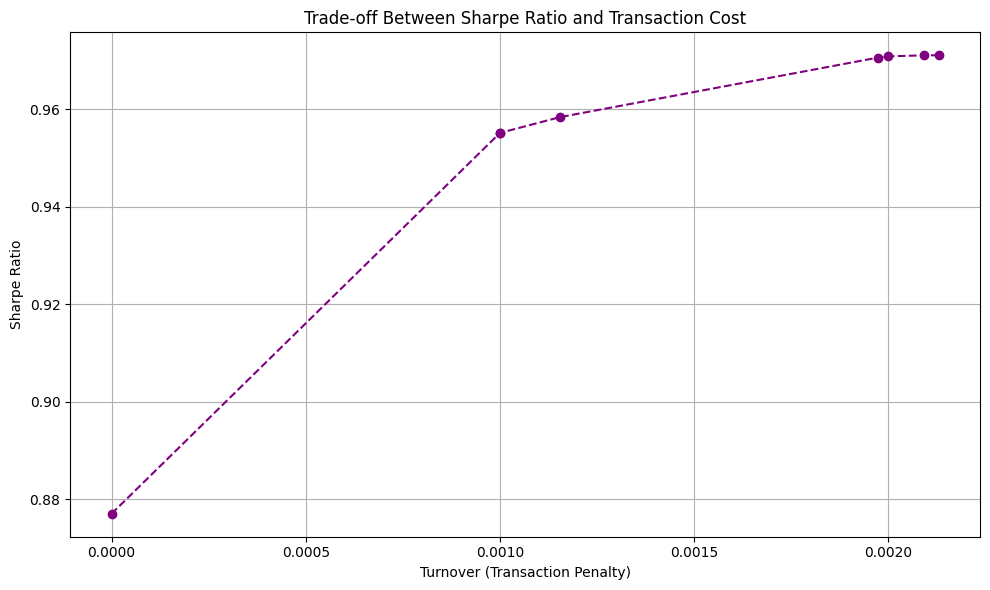

In [7]:
#plotting the results for better visualization
plt.figure(figsize=(10, 6))
plt.plot(turnovers, sharpes, marker='o', linestyle='--', color='purple')
plt.xlabel("Turnover (Transaction Penalty)")
plt.ylabel("Sharpe Ratio")
plt.title("Trade-off Between Sharpe Ratio and Transaction Cost")
plt.grid(True)
plt.tight_layout()
plt.savefig("../Reports/Charts/Tradeof_fBetween_Sharpe_Ratio_and_Transaction_Cost.png")
plt.show()


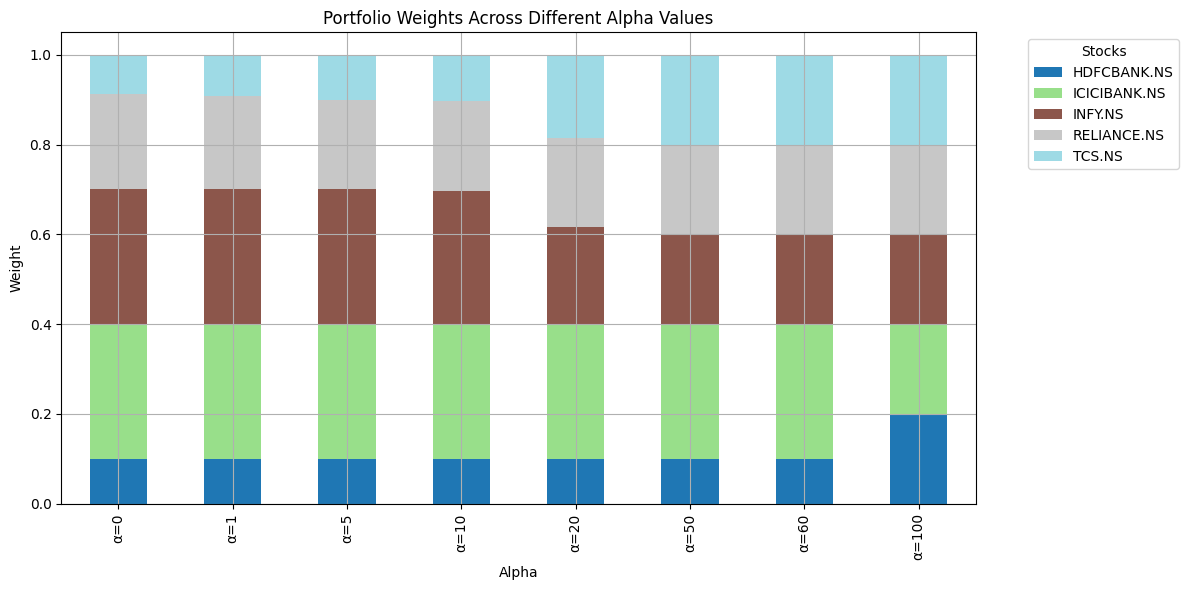

In [8]:
#plotting the portfolio weights across different alpha values
# This will help visualize how the weights change with different penalties
all_weights = []

for alpha in alphas:
    def penalized_objective(w):
        exp_ret = expected_returns.values.flatten()
        ret = np.dot(w, exp_ret)
        vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        sharpe = (ret - risk_free_rate) / vol
        transaction_penalty = np.sum(transaction_costs * np.abs(w - current_weights))
        return -sharpe + alpha * transaction_penalty 

    result = minimize(
        penalized_objective,
        x0=np.ones(len(expected_returns)) / len(expected_returns),
        method='SLSQP',
        bounds=bounds,
        constraints=all_constraints  
    )
    if result.success:
        all_weights.append(result.x)

weights_df = pd.DataFrame(all_weights, columns=tickers, index=[f"α={a}" for a in alphas])

# Plot stacked bar
weights_df.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title("Portfolio Weights Across Different Alpha Values")
plt.ylabel("Weight")
plt.xlabel("Alpha")
plt.legend(title="Stocks", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.savefig("../Reports/Charts/Portfolio_Weights_Across_Different_Alpha_Values.png")
plt.show()


In [9]:
#saving the results to CSV files
results_df = pd.DataFrame({
    'Alpha': alphas,
    'Sharpe Ratio': sharpes,
    'Turnover': turnovers
})
weights_df.index.name = 'Alpha'
weights_df.to_csv("../Reports/weights_for_different_alpha.csv")
results_df.to_csv("../Reports/transaction_cost_tradeoff.csv", index=False)


In [ ]:
# Function to optimize the minimum volatility portfolio with transaction costs
def transaction_cost_min_vol_objective(w_new, cov_matrix, w_current, alpha, transaction_costs):
    port_vol = np.sqrt(np.dot(w_new.T, np.dot(cov_matrix, w_new)))
    penalty = np.sum(transaction_costs * np.abs(w_new - w_current))
    return float(port_vol + alpha * penalty)

alpha_minvol = 1  # You can adjust this value as needed

result_minvol = minimize(
    transaction_cost_min_vol_objective,
    x0=current_weights,
    args=(cov_matrix, current_weights, alpha_minvol, transaction_costs),
    method='SLSQP',
    bounds=bounds,
    constraints=all_constraints
)

if result_minvol.success:
    minvol_weights = result_minvol.x
    print("Transaction cost optimized minimum volatility portfolio weights:")
    for ticker, weight in zip(tickers, minvol_weights):
        print(f"{ticker}: {weight:.4f}")
else:
    print("Optimization failed for minimum volatility portfolio.")

Transaction cost optimized minimum volatility portfolio weights:
HDFCBANK.NS: 0.2138
ICICIBANK.NS: 0.1862
INFY.NS: 0.1001
RELIANCE.NS: 0.2000
TCS.NS: 0.2999


#  Portfolio Optimization with Transaction Costs

##  Overview

In this notebook, we explore how **transaction costs** impact portfolio rebalancing. This feature is crucial for investors who already hold a portfolio and wish to adjust their allocations.

---

##  Methodology

- **Transaction Cost Assumption:**  
  We assume a constant transaction cost of **0.5%** for buying or selling any stock. While real-world costs can be estimated from bid-ask spreads, we use a fixed rate for simplicity.

- **Penalty Calculation:**  
  1. Compute the change in investment for each stock (final minus initial allocation).
  2. Multiply this change by the transaction cost percentage to obtain the **penalty**.

- **Trade-off Parameter (Alpha):**  
  - We introduce a parameter **alpha** (λ), which controls the trade-off between maximizing returns and minimizing transaction costs.
  - **High alpha:** Prioritizes returns, even if transaction costs are high.
  - **Low alpha:** Accepts lower returns to reduce transaction costs.

---

##  Experimentation

- **Single Alpha Simulation:**  
  Simulate the portfolio optimization for a single alpha value to observe the effect.

- **Multiple Alpha Analysis:**  
  Loop through various alpha values to analyze how the trade-off affects portfolio turnover and performance.

---

##  Key Observations

- **Turnover vs. Sharpe Ratio:**  
  Higher Sharpe ratios are generally associated with higher transaction cost penalties.

- **Portfolio Weights Comparison:**  
  - **Low alpha:** Allows for significant reallocation, resulting in portfolios that differ more from the original.
  - **High alpha:** The optimized portfolio closely resembles the original, indicating minimal changes due to high penalty sensitivity.
  - **Medium to low alpha:** Portfolios have similar weights, suggesting these alpha values offer a balanced trade-off.

---

##  Data Storage

All results, including weights for different alphas and turnover statistics, are saved as CSV files for further analysis.

---

>  **Conclusion:**  
> Factoring in transaction costs is essential for realistic portfolio optimization. By tuning alpha, investors can control how much they are willing to trade off between maximizing returns and minimizing costs.